### Данные - Ирисы Фишера

В задаче будет рассмотрена реальная выборка - ирисы Фишера, по 3 и 4 признаку, т.е. petalLength и petalWidth.

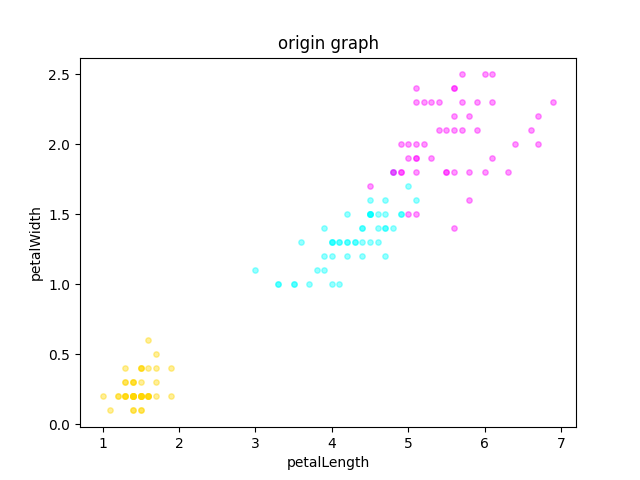


### Описание алгоритма

Отличие линейного дискриминанта Фишера от предыдущих двух методов заключается в предположении об едниой ковариационной матрице для распределений каждого класса.
Оценка, приносящая максимум правдоподобия выглядит так:

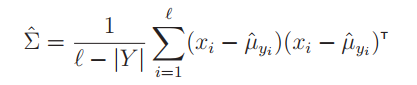

Линейный в названии означает, что разделяющая поверхность линейна, если классов два, и кусочно-линейна, если несколько. Это видно из выкладки, если подставить на место ковариационной матрицы указанную выше оценку:

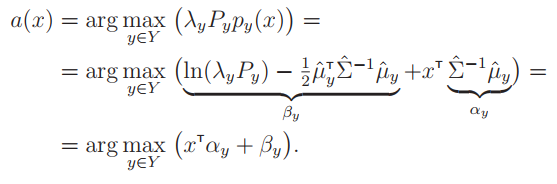

Оценки центров, т.е. математических ожидание остаются прежними:

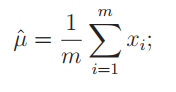

### Код программы

Класс, реализующий дискриминант фишера унаследован от класса дискриминантных функций:

In [ ]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd


class AbstractDisc(ABC):
    _objects: list
    _answers: list
    answer_set: list

    cases_count: int
    component_count: int

    classes_errors: dict
    cases_by_classes: dict
    classes_probabilities: dict

    centers: dict
    covariance: dict

    def __init__(self, objects: pd.DataFrame, answers: pd.DataFrame, cl_errors: dict = None, is_column_name=True):
        if is_column_name:
            objects.columns = objects.iloc[0]
            answers.columns = answers.iloc[0]
        self.objects = objects
        self.answers = answers
        if cl_errors is None:
            self.classes_errors = dict()
            for y in self.answer_set:
                self.classes_errors[y] = 1
        self.component_count = len(self.objects[0][1])
        self.cases_count = len(self.objects)
        self.cases_by_classes_init()
        self.classes_probabilities_init()

    @property
    def objects(self):
        return self._objects

    @objects.setter
    def objects(self, val):
        self._objects = []
        for index, obj in val.iterrows():
            self._objects.append((index, np.array(obj)))

    @property
    def answers(self):
        return self._answers

    @answers.setter
    def answers(self, val):
        self._answers = []
        for _, answer in val.iterrows():
            self._answers.append(answer.tolist()[0])
        # Формирование упорядоченого множества
        self.answer_set = list(dict.fromkeys(self._answers))

    def cases_by_classes_init(self):
        self.cases_by_classes = dict.fromkeys(self.answer_set)

        for key in self.cases_by_classes:
            self.cases_by_classes[key] = dict()

        for x in self.objects:
            y = self.answers[x[0]]
            self.cases_by_classes[y][x[0]] = x

    def classes_probabilities_init(self):
        self.classes_probabilities = dict()
        for y in self.answer_set:
            self.classes_probabilities[y] = float(len(self.cases_by_classes[y])) / self.cases_count

    @abstractmethod
    def centers_init(self, *args):
        pass

    @abstractmethod
    def covariance_init(self, *args):
        pass

    @abstractmethod
    def gamma(self, x, y):
        pass

    def classify(self, x, is_new_element=True, *args):
        if not is_new_element:
            x = x[1]

        max_gamma = None
        arg_max = None
        for y in self.answer_set:
            gamma = self.gamma(x, y)
            if max_gamma is None or gamma > max_gamma:
                max_gamma = gamma
                arg_max = y
        return arg_max
    
    def error(self):
        incorrect_object_answer = 0
        for x in self.objects:
            a = self.classify(x, False)
            if a != self.answers[x[0]]:
                incorrect_object_answer += 1
        return incorrect_object_answer / self.cases_count

Класс, реализующий дискриминант фишера представлен ниже. 

In [ ]:
import numpy as np
import pandas as pd
import abstract_disc_class as abs_dc


class FisherDiscriminant(abs_dc.AbstractDisc):
    cl_comp_dispersions_invert: np.matrix

    def __init__(self, objects: pd.DataFrame, answers: pd.DataFrame, cl_errors: dict = None, is_column_name=True):
        super().__init__(objects, answers, cl_errors, is_column_name)
        self.centers_init()
        self.covariance_init()

    def centers_init(self):
        self.centers = dict()
        for y in self.answer_set:
            self.centers[y] = []

        for y in self.answer_set:
            res = np.zeros(self.component_count)
            m = self.cases_by_classes[y].keys()
            for i in m:
                x = self.cases_by_classes[y][i][1]
                res += x
            self.centers[y] = np.array(res / len(m))

    def covariance_init(self):
        res = np.zeros((self.component_count, self.component_count))
        for i in range(self.cases_count):
            x = self.objects[i]
            y = self.answers[x[0]]
            element = x[1] - self.centers[y]
            res += np.outer(element, element)
        self.covariance = res / (self.cases_count - len(self.answer_set))
        self.cl_comp_dispersions_invert = np.linalg.inv(self.covariance)

    def gamma(self, x, y):
        m_ex_t = self.centers[y]
        m_ex = np.matrix(self.centers[y]).T
        x_t = np.matrix(x)

        alpha = self.cl_comp_dispersions_invert * m_ex
        beta = np.log(self.classes_errors[y] * self.classes_probabilities[y])
        beta -= 0.5 * np.matmul(m_ex_t, self.cl_comp_dispersions_invert) * m_ex
        return np.asscalar(x_t * alpha + beta)
    
    def error(self):
        incorrect_object_answer = 0
        for x in self.objects:
            a = self.classify(x, False)
            if a != self.answers[x[0]]:
                incorrect_object_answer += 1
        return incorrect_object_answer / self.cases_count

### Результаты

Карта классификации имеет вид:

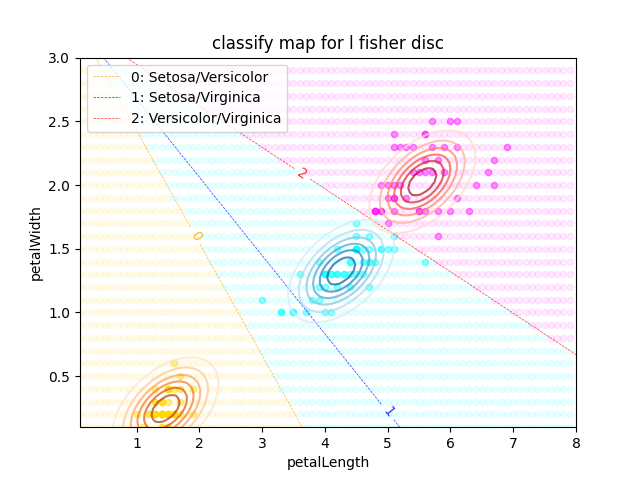

Ошибка классификации равна 1/25

### Преимущества

Сравним все предыдущие методы между собой на выборке ирисов Фишера. 

*   Наивный байесовский алгоритм - 1/25
*   Подстановочный алгоритм - 1/30
*   Линейный дискриминант Фишера - 1/25

Видно, что лучше всего с классификацие справляется подстановочный алгоритм, за ним идет ЛДФ и наивный байесовский алгоритм. Однако у каждого из этих методов свои достоинства и недостатки: 


*   Для наивного байесовского метода необходимо хранить диагональ ковариационной матрицы и центр для каждой компоненты и класса.

*   Для подстановочного метода необходимо хранить не только диагональ, но вообще всю матрицу, а также центр для каждого класса. Если в случае наивного байсесовского метода обращение и перемножение матриц не требовалось, то для plug-in метода уже придется выполнять дорогостоящие операции.

*   На фоне предыдущих методов, дискриминант фишера является наиболее вычислительно эффективным. Это связанно с тем, что для рассматриваемого метода необходимо хранить, и обращать одну матрицу для всех классов.

Таким образом, основное преимущество дискриминанта фишера, заключается в том, что его вычислительная сложность не зависит от количества классов, что позволяет применять этот метод в выборках с большим их количеством, однако, если же требуется большая точность, то стоит рассмотреть предыдущие классы.

# Итог

Подводя итог для каждого метода из группы нормального дискриминантного анализа можно выделить структуры выборок для каждого из них:

1. Наивный байесовский алгоритм - хорош для выборок, с двумя независимыми или малозависимыми признаками. Обладает степенью свободы в виде "масштабирования" формы нормального распределения.

2. Подстановочный метод - неплохо работает для неравномерных выборок, в смысле форм классов. Т.е. в таких выборках, где не только существует зависимость между признаками, но и для каждого класса эта зависимость различна. Самый универсальный класс.

3. Линейный дискриминант фишера - дает неплохой результат, когда вероятно предположение об одинаковой природе происхождения классов.

Важно понимать, что если к примеру подстановочный метод дает картину, при которой классы почти равны по форме нормального распределения, то есть смысл перейти в такой выборке на ЛДФ. Если формы различаются только по масштабу, то перейти к НБА.
